In [1]:
import tweepy
import json
import time
import datetime
import os
import itertools
import os
import csv
import pandas as pd
import numpy as np
from scipy.sparse import vstack, hstack
from scipy.sparse import csr_matrix
import re
from string import digits

import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tag.stanford import StanfordNERTagger
from nltk.stem import WordNetLemmatizer

from gensim.models.phrases import Phrases

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from matplotlib import pyplot as plt

In [2]:
#Api credentials
consumer_key = "JYGzzjhuiUoI4W6j0lj9i1lCx"
consumer_secret = "p00uHIuFeQPLGfzu0uYDTzcXumeCrpmxdkn8xPvqDh1GtI1lXT"
access_token_key = "1218878730405322752-X7c55wLQ2WJCIGGpVhvy7Vild3towe"
access_token_secret = "XV4j2sjf4aEIjKgKfxIELeQcEXeuElLNm3D4h4QRnS4w4"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api  = tweepy.API(auth)

In [3]:
if api.me():
    print("Authenticated\n")
else:
    print("Error in Authentication\n")

Authenticated



# Download tweets by hashtag

In [4]:
path_out = "C:/Users/namja/Desktop/df_tweets_" + str(datetime.date.today()) + '.csv'


hashtag_list_en = ["#COVID19", "#coronaavirus", "#SARSCoV2", "#Covid-19", "#SocialDistancing", "#LockdownNow", "#COVIDIOT"]
hashtag_list_it = ["#COVID19", "#coronaavirus", "#SARSCoV2", "#Covid-19", "#SocialDistancing", "#coronavirusitalia", "#andratuttobene", "#COVIDIOT"]

In [5]:

no_retweet   = " -filter:retweets"
language     = ["en", "it"]
today        = datetime.date.today().strftime("%Y-%m-%d")
period       = " until:" + today


In [6]:
flag_header = True

if flag_header == True:
    with open(path_out, "w") as o:
        o.write("hashtag|timestamp|tweet_text|user_name|language\n") # solo una volta al giorno

        flag_header = False

In [7]:
counter = 0
times   = 0

while times <= 100: # inserire un numero piu' grande

    for lang in language:

        if lang == "en":
            hashtag_list = hashtag_list_en
        else:
            hashtag_list = hashtag_list_it

        for hash in hashtag_list:

            query = hash + no_retweet + period + " lang:" + lang

            try:

                for page in tweepy.Cursor(api.search, q=query, tweet_mode = "extended").pages():
                    for status in page:

                        try:
                            full_text = status.full_text.replace("\n", " ").replace("|", "").encode("utf-8").decode("ascii", "ignore")
                            url_to_rm = re.search("(?P<url>https?://[^\s].+)", full_text).group("url") # cerca https in tweet

                            text      = full_text.replace(url_to_rm, "").strip().replace("  ", " ") # toglie https in tweet
                            time_data = str(status.created_at)
                            user_name = status.user.screen_name
                            # print str(counter) + " : " + text
                            counter += 1
                            print(str(counter), ":", hash)
                        except:

                            text      = status.full_text.replace("\n", " ").replace("|", "").encode("utf-8").decode("ascii", "ignore").strip().replace("  ", " ")
                            time_data = str(status.created_at)
                            user_name = status.user.screen_name
                            # print str(counter) + " : " + text
                            counter += 1
                            print(str(counter), ":", hash)

                        raw_line = str(hash + "|" + time_data + "|" + text + "|" + user_name + "|" + lang)

                        with open(path_out, "a") as o:
                            o.write(raw_line + '\n')

                        # print(str(counter))
                        time.sleep(0.1)

            except Exception as e:
                print(e)
                print("\n\nSuperato il limite, aspetto 15 minuti")

                time.sleep(15 * 60 + 1)

    times += 1


1 : #COVID19
2 : #COVID19
3 : #COVID19
4 : #COVID19
5 : #COVID19
6 : #COVID19
7 : #COVID19
8 : #COVID19
9 : #COVID19
10 : #COVID19
11 : #COVID19
12 : #COVID19
13 : #COVID19
14 : #COVID19
15 : #COVID19
16 : #COVID19
17 : #COVID19
18 : #COVID19
19 : #COVID19
20 : #COVID19
21 : #COVID19
22 : #COVID19


KeyboardInterrupt: 

# Preprocessing tweet's text

In [8]:
#apply functions to clean the data

def clean_up(line):

    line = line \
        .replace('<i>', '').replace('</i>', '').replace('...', '') \
        .replace(',', '').replace('.','').replace(';','').replace('?','').replace('!','')\
        .replace('[', "").replace(']', "").replace('=', '') \
        .replace('(', '').replace(')', '').replace('$', '').replace('  ', ' ') \
        .replace('"', '').replace(':', '').replace('{', '').replace('-', '') \
        .replace('}', '').replace('@', '').replace('&','') \
        .replace('^','').replace('*','').replace('+','').replace('/','') \
        .replace('\\','').replace('|','').replace('%','').replace("#", " #") \
        .replace('\"','').replace('  ', ' ').replace('    ', ' ')

    try:
        for f in set(re.findall('\<.*?\>', line)): 
            line = line.replace(f, '')
            line = line.replace('<', '').replace('>', '')

    except:
        line = line.strip()

    try:
        line = re.sub('font color\d*\w*\d', '', line) 
    except:
        line = line.strip()
    try:
        line = re.sub('font color\d*', '', line) 
    except:
        line = line.strip()
    try:
        for d in re.findall('\d', line):
            line = line.replace(str(d[0]), "")

    except:
        line = line.strip()

    return line.strip().replace('  ',' ')



def clean_text(text_column, stopwords_list):

    tweets_text               = [str(tweet).lower() for tweet in text_column]
    testi_corretti            = list(map(lambda x: clean_up(str(x)), tweets_text))
    testi_corretti_tokenized_ = [token for token in [tweet.split() for tweet in testi_corretti]]

    bigram_model = Phrases(testi_corretti_tokenized_) 

    testi_corretti_tokenized_bigram = []
    for unigram_sentence in testi_corretti_tokenized_:
            testi_corretti_tokenized_bigram.append(bigram_model[unigram_sentence])   

    testi_corretti_tokenized_bigram_no_stopwords = [[word for word in tweet if word not in stopwords_list] for tweet in testi_corretti_tokenized_bigram]

    return testi_corretti_tokenized_bigram_no_stopwords


def lemmatizer_custom(doc):
    res = ' '.join(map(lambda x: lemmatizer_nltk.lemmatize(x, get_wordnet_pos(x)), doc))
    return res





In [9]:
path_stopwords             = "C:/Users/namja/Desktop/covid_tweet/stopwords-en.txt"
path_in_our_tweets         = "C:/Users/namja/Desktop/covid_tweet/total_tweets.csv" 
df                         = pd.read_csv(path_in_our_tweets, sep = "|", header= 0, error_bad_lines=False)
df                         = df.drop_duplicates(subset="tweet_text") 
df = df.rename(columns={'language,,,,,,,,,,,,,,,,,,,,,,,': 'language'})
df.columns

Index(['hashtag', 'timestamp', 'tweet_text', 'user_name', 'language'], dtype='object')

In [10]:
df.shape

(29319, 5)

In [11]:
df = df.replace("en,,,,,,,,,,,,,,,,,,,,,", "en")
df = df.replace("en,,,,,,,,,,,,,,,,,,,,,,", "en")
df = df.replace("en,,,,,,,,,,,,,,,,,,,,,,,", "en")
df = df.replace("en,,,,,,,,,,,,,,,,,,,,", "en")
df = df.replace("it,,,,,,,,,,,,,,,,,,,,,,", "it")
df = df.replace("it,,,,,,,,,,,,,,,,,,,,,", "it")
df = df.replace("it,,,,,,,,,,,,,,,,,,,,,,,", "it")
df.dropna()
df.sample(20)

,hashtag,timestamp,tweet_text,user_name,language
18298,#Covid-19,2020-06-28 23:52:48,".@JustinTrudeau, The epidemic is worsening. 17...",stewartetcie,"en,,,,,,,,,,,"
36050,#Covid-19,2020-06-30 23:40:24,Ice-T says wife Coco Austin's father has COVID-19,SoLaTiDoBlades,en
38072,#SocialDistancing,2020-06-30 12:57:13,It's not over yet #WearAMask #StayHome stay sa...,lynda3035,en
26400,#Covid-19,2020-06-28 23:03:59,Ecco a voi il NWO ! Agenda 2030 nella sua pien...,FunkyDancer_,it
13339,#Covid-19,2020-06-26 11:30:33,Tales of Arise - Rimandato oltre il 2020 a cau...,GameIndustry_IT,it
34092,#Covid-19,2020-06-30 23:58:11,@DIESELPATRIOT1 @sliceman420 @GregAbbott_TX Co...,trainer1995,en
718,#COVID19,2020-06-27 23:27:17,"Coming soon #WhatPinaDrew, a collaboration bet...",girlsdrwingirls,en
37148,#SocialDistancing,2020-06-30 19:00:00,The autonomatons are social distancing #Preven...,KrakoaWelcomes,en
15933,#COVID19,2020-06-28 22:29:00,@Mike_Pence @GovAbbott @realDonaldTrump You we...,Dist_5,en
21093,#COVIDIOT,2020-06-28 20:50:01,@BrynnTannehill Another #COVIDIOT,saraccrow,en


In [12]:
df.user_name.describe()

count               29295
unique              21696
top       generacomplotti
freq                   99
Name: user_name, dtype: object

In [13]:
df.groupby('hashtag').describe()

timestamp         \
                                                       count unique   
hashtag                                                               
#COVID19                                                9105   7864   
#COVID19|2020-06-25 19:50:56|@CesareSacchetti @...         1      1   
#COVID19|2020-06-26 15:33:40|Secondo "Vite Sott...         1      1   
#COVID19|2020-06-27 13:43:34|"Piccoli focolai, ...         1      1   
#COVID19|2020-06-27 16:16:00|"Grazie al #report...         1      1   
#COVID19|2020-06-27 17:24:45|@Agenzia_Italia A ...         1      1   
#COVID19|2020-06-27 20:03:27|@ilgiornale Scusat...         1      1   
#COVID19|2020-06-27 20:25:03|#27giugno Una doma...         1      1   
#COVID19|2020-06-27 21:22:20|"[...] non solo un...         1      1   
#COVID19|2020-06-27 23:08:38|New at @marxistsoc...         1      1   
#COVID19|2020-06-27 23:24:54|These morons &amp;...         1      1   
#COVID19|2020-06-27 23:27:37|"Each man's death ...         1      1   
#COVID19|2020-06-27 23:37:23|This is NOT good n...         1      1   
#COVID19|2020-06-27 23:52:46|Here's my "virtual...         1      1   
#COVID19|2020-06-27 23:55:16|#COVID19 update fo...         1      1   
#COVID19|2020-06-27 23:56:25|@renato_mariotti P...         1      1   
#COVID19|2020-06-27 23:57:07|".@Mike_Pence stil...         1      1   
#COVID19|2020-06-27 23:59:55|#Covidhoax #VirusH...         0      0   
#COVID19|2020-06-28 22:51:24|My neighbor from F...         1      1   
#COVIDIOT                                               4896   4880   
#Covid-19                                               7995   5575   
#Covid-19|2020-06-26 14:04:27|Volpi (IREF): "Se...         1      1   
#Covid-19|2020-06-27 08:45:13|" mia opinione ch...         1      1   
#Covid-19|2020-06-27 23:39:20|"Please do not fl...         1      1   
#Covid-19|2020-06-28 19:00:14|"Questi mesi, con...         1      1   
#Covid-19|2020-06-30 23:59:31|@realDonaldTrump ...         1      1   
#LockdownNow                                              38     38   
#SARSCoV2                                               1877   1850   
#SARSCoV2|2020-06-26 17:20:01|The "mild" of #Co...         1      1   
#SocialDistancing                                       4772   4673   
#andratuttobene                                          212    212   
#coronaavirus                                              2      2   
#coronavirusitalia                                       398    398   

                                                                              \
                                                                    top freq   
hashtag                                                                        
#COVID19                                            2020-06-30 23:00:00   10   
#COVID19|2020-06-25 19:50:56|@CesareSacchetti @...       legionarionero    1   
#COVID19|2020-06-26 15:33:40|Secondo "Vite Sott...            tobiazevi    1   
#COVID19|2020-06-27 13:43:34|"Piccoli focolai, ...          DanielaPF75    1   
#COVID19|2020-06-27 16:16:00|"Grazie al #report...       siamonoitv2000    1   
#COVID19|2020-06-27 17:24:45|@Agenzia_Italia A ...          PaoloBrandi    1   
#COVID19|2020-06-27 20:03:27|@ilgiornale Scusat...      JacopoLancioni1    1   
#COVID19|2020-06-27 20:25:03|#27giugno Una doma...            il_Giangi    1   
#COVID19|2020-06-27 21:22:20|"[...] non solo un...          AnnaPerla15    1   
#COVID19|2020-06-27 23:08:38|New at @marxistsoc...      Crit_Social_Sci    1   
#COVID19|2020-06-27 23:24:54|These morons &amp;...       YummyTaterTots    1   
#COVID19|2020-06-27 23:27:37|"Each man's death ...       FrancisWasHere    1   
#COVID19|2020-06-27 23:37:23|This is NOT good n...         EthanBearman    1   
#COVID19|2020-06-27 23:52:46|Here's my "virtual...       MediciVendetta    1   
#COVID19|2020-06-27 23:55:16|#COVID19 update fo...       GrumpyOldAstro    1   
#COVID19|2020-06-27 23:56:25|@renato_mariotti P...    

In [14]:

df = df.drop(df[df["timestamp"] =="legionarionero"].index)
df = df.drop(df[df["timestamp"] =="tobiazevi"].index)
df = df.drop(df[df["timestamp"] =="DanielaPF75"].index)
df = df.drop(df[df["timestamp"] =="siamonoitv2000"].index)
df = df.drop(df[df["timestamp"] =="PaoloBrandi"].index)
df = df.drop(df[df["timestamp"] == "JacopoLancioni1"].index)
df = df.drop(df[df["timestamp"] =="il_Giangi"].index)
df = df.drop(df[df["timestamp"] =="Crit_Social_Sci"].index)
df = df.drop(df[df["timestamp"] =="YummyTaterTots"].index)
df = df.drop(df[df["timestamp"] =="FrancisWasHere"].index)
df = df.drop(df[df["timestamp"] =="	EthanBearman"].index)
df = df.drop(df[df["timestamp"] =="MediciVendetta"].index)
df = df.drop(df[df["timestamp"] =="GrumpyOldAstro"].index)
df = df.drop(df[df["timestamp"] =="MarkWhittier1"].index)
df = df.drop(df[df["timestamp"] =="_Savage_Mom_"].index)
df = df.drop(df[df["timestamp"] =="JoyGrenade"].index)
df = df.drop(df[df["timestamp"] =="iref_ricerche"].index)
df = df.drop(df[df["timestamp"] =="NICOLACATAR"].index)
df = df.drop(df[df["timestamp"] =="wlybrand"].index)
df = df.dropna()

In [15]:
df.groupby('hashtag').describe()

timestamp                                  tweet_text  \
                       count unique                  top freq      count   
hashtag                                                                    
#COVID19                9105   7864  2020-06-30 23:00:00   10       9105   
#COVIDIOT               4896   4880  2020-06-24 22:40:02    2       4896   
#Covid-19               7995   5575  2020-06-27 23:30:00   15       7995   
#LockdownNow              38     38  2020-06-21 12:56:26    1         38   
#SARSCoV2               1877   1850  2020-06-28 10:14:03    4       1877   
#SocialDistancing       4772   4673  2020-06-30 16:26:57    3       4772   
#andratuttobene          212    212  2020-06-24 11:09:25    1        212   
#coronaavirus              2      2  2020-06-24 23:03:54    1          2   
#coronavirusitalia       398    398  2020-06-25 12:55:07    1        398   

                                                                              \
                   unique                                                top   
hashtag                                                                        
#COVID19             9105  Ci vuole equilibrio nell'analisi non oscillare...   
#COVIDIOT            4896  In March the #Covidiot stated that #Covid19 wo...   
#Covid-19            7995  GLOBAL GOAL CONCERT Watch some of the biggest ...   
#LockdownNow           38  #GeorgeUseless suggesting people ARE following...   
#SARSCoV2            1877  #Phoenix #Arizona ICU overflowing... #COVID19 ...   
#SocialDistancing    4772  Get Open The Door With Feet And Elbow Wall Pos...   
#andratuttobene       212  See you in my little living room studio... Sch...   
#coronaavirus           2  PLANO NOW ...The Trump Administration  ...Has ...   
#coronavirusitalia    398  #ottoemezzo #MassimoGalli l'unico di seguire i...   

                        user_name                              language  \
                   freq     count unique              top freq    count   
hashtag                                                                   
#COVID19              1      9105   6757       paoloigna1   56     9105   
#COVIDIOT             1      4896   3569   GaleCGeorgalas   28     4896   
#Covid-19             1      7995   6766  giovanniproto67   44     7995   
#LockdownNow          1        38     20     TValentine62   10       38   
#SARSCoV2             1      1877    996  generacomplotti   73     1877   
#SocialDistancing     1      4772   3891     Hotpage_News   86     4772   
#andratuttobene       1       212    166     CinesinBambu    8      212   
#coronaavirus         1         2      2        Plano_Now    1        2   
#coronavirusitalia    1       398    202         Righeblu   15      398   

                                     
                   unique top  freq  
hashtag                              
#COVID19               33  en  5556  
#COVIDIOT              15  en  4713  
#Covid-19              33  en  4890  
#LockdownNow            2  en    37  
#SARSCoV2              21  en  1600  
#SocialDistancing      17  en  4587  
#andratuttobene         8  it   196  
#coronaavirus           1  en     2  
#coronavirusitalia      6  it   360

In [16]:
df.head()

,hashtag,timestamp,tweet_text,user_name,language
0,#COVID19,2020-06-27 23:59:55,@TeamTrump @jepence @Paula_White @JohnnieM @Pa...,alexizedM,"en,,,,,,,,,,,,,,,,,,,"
2,#COVID19,2020-06-27 23:59:53,Check out this amazing video by some of Latin ...,ao_murph,en
4,#COVID19,2020-06-27 23:59:52,#Insiders Promoting the myth that #COVID19 has...,Bukumbooee,en
5,#COVID19,2020-06-27 23:59:49,#Coronavirus in the U.S.: Latest Map and Case ...,PamMktgNut,en
6,#COVID19,2020-06-27 23:59:47,UPDATE ON #COVID19 CASES IN ARKANSAS: The ADH ...,clarbusta,en


In [17]:
df.tail()

,hashtag,timestamp,tweet_text,user_name,language
41333,#COVIDIOT,2020-06-28 03:24:49,your freedom to infect me with #coronavirus is...,GPWriter,en
41335,#COVIDIOT,2020-06-28 03:23:43,@JoshuaPotash crazy...I live in California and...,GPWriter,en
41359,#COVIDIOT,2020-06-28 02:56:20,Does anyone want to tell #BunkerBabyInChief ho...,CulturalDead,en
41438,#COVIDIOT,2020-06-28 00:52:26,@DonaldJTrumpJr Youre a #COVIDIOT,previouslife17,en
41451,#COVIDIOT,2020-06-28 00:19:18,@feysund no its common sense and science the v...,GPWriter,en


In [18]:
df = df[df.language != "it"]
df.tail()

,hashtag,timestamp,tweet_text,user_name,language
41333,#COVIDIOT,2020-06-28 03:24:49,your freedom to infect me with #coronavirus is...,GPWriter,en
41335,#COVIDIOT,2020-06-28 03:23:43,@JoshuaPotash crazy...I live in California and...,GPWriter,en
41359,#COVIDIOT,2020-06-28 02:56:20,Does anyone want to tell #BunkerBabyInChief ho...,CulturalDead,en
41438,#COVIDIOT,2020-06-28 00:52:26,@DonaldJTrumpJr Youre a #COVIDIOT,previouslife17,en
41451,#COVIDIOT,2020-06-28 00:19:18,@feysund no its common sense and science the v...,GPWriter,en


In [19]:
df.shape

(23278, 5)

In [20]:
df['id'] = [str(id) for id in list(range(df.shape[0]))]

In [21]:
path_stopwords       = "C:/Users/namja/Desktop/covid_tweet/stopwords-en.txt"

In [22]:
stopwords_en = []
with open(path_stopwords, "r", errors = 'ignore') as f:
    for line in csv.reader(f, delimiter='\n'):
        stopwords_en.extend(line)

In [23]:
#applying tokenization
tweets_text               = [str(tweet).lower() for tweet in df['tweet_text']]
testi_corretti            = list(map(lambda x: clean_up(str(x)), tweets_text))
testi_corretti_tokenized  = [token for token in [tweet.split() for tweet in testi_corretti]]

In [24]:
testi_corretti_tokenized

[['teamtrump',
  'jepence',
  'paula_white',
  'johnniem',
  'pastorsamuelr',
  'in',
  'a',
  'matter',
  'of',
  'months',
  'trump',
  'has',
  'screwed',
  'america',
  'twice',
  'in',
  'jan',
  'after',
  'he',
  'was',
  'briefed',
  'about',
  '#covid',
  'he',
  'ignored',
  'it',
  'amp',
  'called',
  'it',
  'a',
  'hoax',
  'virus',
  'spread',
  'killed',
  'thousands',
  'then',
  'we',
  'had',
  'to',
  'shutdown',
  'to',
  'control',
  'its',
  'spread',
  'then',
  'he',
  'forced',
  'reopening',
  'too',
  'early',
  'amp',
  'now',
  'were',
  'spreading',
  'again'],
 ['check',
  'out',
  'this',
  'amazing',
  'video',
  'by',
  'some',
  'of',
  'latin',
  'americas',
  'hottest',
  'artists',
  'every',
  'view',
  'helps',
  'raise',
  'money',
  'for',
  'the',
  'pan',
  'american',
  'health',
  'organization',
  'opsoms',
  'to',
  'fight',
  '#covid',
  'share',
  'everywhere',
  'to',
  'help',
  'save',
  'lives',
  'sonymusiclatin',
  '#streamforhop

# sentimental analysis

In [25]:
#get text polarity scores
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()
t   = testi_corretti[112]
sia.polarity_scores(t)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\namja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.134, 'neu': 0.866, 'pos': 0.0, 'compound': -0.4767}

In [26]:

list_neg  = []
list_neu  = []
list_pos  = []
list_comp = []

for t in testi_corretti:

    polarity = sia.polarity_scores(t)

    list_neg.append(polarity["neg"])
    list_pos.append(polarity["pos"])
    list_neu.append(polarity["neu"])
    list_comp.append(polarity["compound"])

In [27]:

df_text_sentiment = pd.DataFrame({"id" : [str(id) for id in list(range(len(testi_corretti)))],
                                "cleaned_text" : testi_corretti,
                                  "negative" : list_neg,
                                  "positive" : list_pos,
                                  "neutral" : list_neu,
                                  "compound" : list_comp})
df_text_sentiment = pd.merge(left=df, right=df_text_sentiment, how="inner", on="id")


(array([  87.,  154.,  225.,  248.,  254.,  275.,  295.,  272.,  287.,
         285.,  333.,  304.,  253.,  484.,  332.,  242.,  260.,  346.,
         242.,  339.,  603.,  264.,  137.,  300.,  159.,  151.,  284.,
         171.,  166.,  151., 6410.,  152.,  279.,  243.,  157.,  189.,
         345.,  146.,  234.,  578.,  266.,  513.,  627.,  586.,  185.,
         434.,  556.,  320.,  270.,  469.,  320.,  352.,  281.,  300.,
         310.,  272.,  233.,  195.,  110.,   43.]),
 array([-9.8460e-01, -9.5179e-01, -9.1898e-01, -8.8617e-01, -8.5336e-01,
        -8.2055e-01, -7.8774e-01, -7.5493e-01, -7.2212e-01, -6.8931e-01,
        -6.5650e-01, -6.2369e-01, -5.9088e-01, -5.5807e-01, -5.2526e-01,
        -4.9245e-01, -4.5964e-01, -4.2683e-01, -3.9402e-01, -3.6121e-01,
        -3.2840e-01, -2.9559e-01, -2.6278e-01, -2.2997e-01, -1.9716e-01,
        -1.6435e-01, -1.3154e-01, -9.8730e-02, -6.5920e-02, -3.3110e-02,
        -3.0000e-04,  3.2510e-02,  6.5320e-02,  9.8130e-02,  1.3094e-01,
         1.

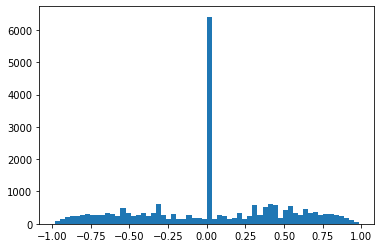

In [28]:
#plot histogram of compound scores
plt.hist(df_text_sentiment['compound'], bins = 60)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 4.000e+00,
        7.000e+00, 9.000e+00, 1.200e+01, 2.200e+01, 1.100e+01, 1.200e+01,
        3.000e+01, 4.800e+01, 5.000e+01, 4.300e+01, 6.100e+01, 8.700e+01,
        1.030e+02, 1.240e+02, 1.600e+02, 1.970e+02, 2.270e+02, 2.440e+02,
        2.930e+02, 3.800e+02, 3.950e+02, 4.370e+02, 5.040e+02, 5.970e+02,
        6.630e+02, 7.450e+02, 7.970e+02, 8.900e+02, 9.380e+02, 8.430e+02,
        1.059e+03, 1.093e+03, 9.000e+02, 1.057e+03, 8.820e+02, 8.660e+02,
        8.130e+02, 7.340e+02, 5.010e+02, 2.300e+02, 3.200e+01, 6.157e+03]),
 array([0.        , 0.01666667, 0.03333333, 0.05      , 0.06666667,
        0.08333333, 0.1       , 0.11666667, 0.13333333, 0.15      ,
        0.16666667, 0.18333333, 0.2       , 0.21666667, 0.23333333,
        0.25      , 0.26666667, 0.28333333, 0.3       

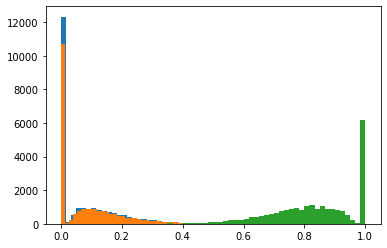

In [29]:
#plot histogram of negative, positive and neutral scores
plt.hist(df_text_sentiment['negative'], bins = 60)
plt.hist(df_text_sentiment['positive'], bins = 60)
plt.hist(df_text_sentiment['neutral'], bins = 60)

In [30]:
df_text_sentiment['compound'].describe()
df_text_sentiment['compound'].median()
df_text_sentiment['compound'].mean()
df_text_sentiment['negative'].describe()

count    23278.000000
mean         0.078322
std          0.109780
min          0.000000
25%          0.000000
50%          0.000000
75%          0.134000
max          1.000000
Name: negative, dtype: float64

In [31]:
df_text_sentiment.to_csv("C:/Users/namja/Desktop/covid_tweet/covid_text_sentiment.csv", sep = "|", index=False)

In [32]:
#get mean_sentiments, binary, three class by using covid_text_sentiments in R.
df_sent = pd.read_csv("C:/Users/namja/Desktop/covid_tweet/covid_text_sentiment_mean1_r.csv" , header = 0, sep = "|") 
# binary: positive = 1, neg = 2
# three: pos = 1, neg = 2, neutral = 0

In [33]:
df_sent.shape

(28534, 16)

In [34]:
df_sent.columns

Index(['hashtag', 'timestamp', 'tweet_text', 'user_name', 'language', 'id',
       'cleaned_text', 'negative', 'positive', 'neutral', 'compound',
       'sentiment_r', 'sentiment_r_norm', 'mean_sentiment', 'binary_class',
       'three_class'],
      dtype='object')

In [35]:
tokenized_texts = [token for token in [str(tweet).split() for tweet in df_sent['tweet_text']]]

In [36]:
#Apply bigram model
bigram_model = Phrases(tokenized_texts)

In [37]:
tokenized_texts_bigrams = []
for unigram_sentence in tokenized_texts:
    tokenized_texts_bigrams.append(bigram_model[unigram_sentence])

In [38]:
    tokenized_texts_bigrams_no_stopwords = [[word for word in tweet if word not in stopwords_en] for tweet in tokenized_texts_bigrams]

In [39]:
unique_string_check =  ' '.join([' '.join(token) for token in [tweet for tweet in tokenized_texts_bigrams_no_stopwords]])

In [40]:
for elem in unique_string_check.split(" "): 
    if re.findall(r"^don\'t_\w+", elem):
        print(elem)

don't_believe
don't_believe
don't_believe
don't_even
don't_forget
don't_have
don't_know
don't_have
don't_care
don't_care
don't_have
don't_have
don't_have
don't_care
don't_care
don't_care
don't_care
don't_believe
don't_want
don't_know
don't_want
don't_understand
don't_care
don't_care
don't_know
don't_believe
don't_care
don't_know
don't_want
don't_have
don't_even
don't_know
don't_want
don't_care
don't_want
don't_care
don't_care
don't_care
don't_have
don't_want
don't_have
don't_know
don't_have
don't_care
don't_care
don't_have
don't_believe
don't_even
don't_forget
don't_forget
don't_know
don't_have
don't_want
don't_forget
don't_forget
don't_care
don't_care
don't_have
don't_know
don't_want
don't_believe
don't_forget
don't_want
don't_have
don't_have
don't_have
don't_want
don't_know
don't_think
don't_want
don't_care
don't_want
don't_have
don't_think
don't_care
don't_have
don't_know
don't_have
don't_know
don't_even
don't_have
don't_have
don't_even
don't_even
don't_have
don't_have
don't_believe

Computing most positive and negative tweets for each hashtag:

In [41]:
df_tweet_sentiments = pd.read_csv("C:/Users/namja/Desktop/covid_tweet/covid_text_sentiment.csv" , header = 0, sep = "|") 

In [42]:
df_tweet_sentiments.shape  

(23278, 11)

In [43]:
df_tweet_sentiments.columns

Index(['hashtag', 'timestamp', 'tweet_text', 'user_name', 'language', 'id',
       'cleaned_text', 'negative', 'positive', 'neutral', 'compound'],
      dtype='object')

In [44]:
df_tweet_sentiments.hashtag.unique

<bound method Series.unique of 0         #COVID19
1         #COVID19
2         #COVID19
3         #COVID19
4         #COVID19
           ...    
23273    #COVIDIOT
23274    #COVIDIOT
23275    #COVIDIOT
23276    #COVIDIOT
23277    #COVIDIOT
Name: hashtag, Length: 23278, dtype: object>

In [45]:
df_tweet_sentiments.nlargest(5, ['positive']) 

,hashtag,timestamp,tweet_text,user_name,language,id,cleaned_text,negative,positive,neutral,compound
22979,#COVIDIOT,2020-06-29 12:22:24,Perfect #COVIDIOT,KeepUsaGreater,en,22979,perfect #covidiot,0.0,0.787,0.213,0.5719
2137,#SARSCoV2,2020-06-25 15:18:44,Enjoying the,phil_misiowiec,en,2137,enjoying the,0.0,0.773,0.227,0.5267
3968,#Covid-19,2020-06-27 23:37:22,I survived Covid-19,bigbankbeia,en,3968,i survived covid,0.0,0.767,0.233,0.5106
17428,#Covid-19,2020-06-30 23:57:41,Covid-19 test: 0/10 recommend lmao,briannaa_24,en,17428,covid test recommend lmao,0.0,0.762,0.238,0.7506
17731,#Covid-19,2020-06-30 23:54:26,Cheers guys,Morfid_plays,en,17731,cheers guys,0.0,0.756,0.244,0.4767


In [46]:
df1 = df_tweet_sentiments.groupby(["hashtag"])

In [47]:
df1.head()

,hashtag,timestamp,tweet_text,user_name,language,id,cleaned_text,negative,positive,neutral,compound
0,#COVID19,2020-06-27 23:59:55,@TeamTrump @jepence @Paula_White @JohnnieM @Pa...,alexizedM,"en,,,,,,,,,,,,,,,,,,,",0,teamtrump jepence paula_white johnniem pastors...,0.239,0.017,0.744,-0.9325
1,#COVID19,2020-06-27 23:59:53,Check out this amazing video by some of Latin ...,ao_murph,en,1,check out this amazing video by some of latin ...,0.056,0.325,0.620,0.9118
2,#COVID19,2020-06-27 23:59:52,#Insiders Promoting the myth that #COVID19 has...,Bukumbooee,en,2,#insiders promoting the myth that #covid has b...,0.152,0.097,0.751,-0.4019
3,#COVID19,2020-06-27 23:59:49,#Coronavirus in the U.S.: Latest Map and Case ...,PamMktgNut,en,3,#coronavirus in the us latest map and case cou...,0.154,0.145,0.701,-0.1027
4,#COVID19,2020-06-27 23:59:47,UPDATE ON #COVID19 CASES IN ARKANSAS: The ADH ...,clarbusta,en,4,update on #covid cases in arkansas the adh rep...,0.000,0.000,1.000,0.0000
1083,#SARSCoV2,2020-06-27 23:44:59,"@BallouxFrancois For TB, the general thinking ...",sanghyuk_shin,en,1083,ballouxfrancois for tb the general thinking is...,0.097,0.158,0.745,0.4019
1084,#SARSCoV2,2020-06-27 23:34:01,@VirusesImmunity @ericsongg OMG. Frightening e...,MichiSchulz89,en,1084,virusesimmunity ericsongg omg frightening evid...,0.070,0.294,0.636,0.8807
1085,#SARSCoV2,2020-06-27 23:32:42,Weekly testing (possibly using Saliva) for #SA...,manal_mehta,en,1085,weekly testing possibly using saliva for #sars...,0.000,0.000,1.000,0.0000
1086,#SARSCoV2,2020-06-27 23:26:07,#SARSCoV2 really doesn't seem to transmit well...,BallouxFrancois,en,1086,#sarscov really doesn't seem to transmit well ...,0.000,0.103,0.897,0.5423
1087,#SARSCoV2,2020-06-27 23:18:32,Do you have #transcriptomics data following #S...,KorcsmarosLab,en,1087,do you have #transcriptomics data following #s...,0.000,0.000,1.000,0.0000


In [48]:
df2= df1.apply(lambda x: x.sort_values(["positive"], ascending=False))

In [49]:
df2

hashtag            timestamp  \
hashtag                                                             
#COVID19           15515            #COVID19  2020-06-30 23:36:36   
                   526              #COVID19  2020-06-27 23:35:08   
                   16924            #COVID19  2020-06-30 22:56:08   
                   8982             #COVID19  2020-06-28 23:28:32   
                   8856             #COVID19  2020-06-28 23:33:57   
...                                      ...                  ...   
#coronavirusitalia 14745  #coronavirusitalia  2020-06-25 10:06:16   
                   14746  #coronavirusitalia  2020-06-25 07:55:07   
                   14749  #coronavirusitalia  2020-06-24 17:09:25   
                   14750  #coronavirusitalia  2020-06-24 17:01:08   
                   14769  #coronavirusitalia  2020-06-21 09:34:30   

                                                                 tweet_text  \
hashtag                                                                       
#COVID19           15515                                        A good read   
                   526                                 Wow. Texas. #COVID19   
                   16924    more truth. I love these! #coronavirus #COVID19   
                   8982                      #COVID19 guys please stay safe   
                   8856   10 minutes of glorious truth. Thanks Joe M #CO...   
...                                                                     ...   
#coronavirusitalia 14745  I Coronavirus sar estinto per decreto. Le azie...   
                   14746  #Coronavirus," @Musumeci_Staff: ""I migranti r...   
                   14749  #CoronaVirusItalia #Fase3 Situazione #24giugno...   
                   14750  Bollettino #PROTEZIONECIVILE: casi positivi in...   
                   14769  sullEspresso in edicola da oggi c questa mia i...   

                                user_name                   language     id  \
hashtag                                                                       
#COVID19           15515        jryerson1                         en  15515   
                   526       IDPharmacist                         en    526   
                   16924        honesgirl                         en  16924   
                   8982   Charlot12825443                         en   8982   
                   8856        FarmerAnon                         en   8856   
...                                   ...                        ...    ...   
#coronavirusitalia 14745       eterefatta  it",,,,,,,,,,,,,,,,,,,,,,  14745   
                   14746  Regione_Sicilia  it",,,,,,,,,,,,,,,,,,,,,,  14746   
                   14749         Righeblu     it,,,,,,,,,,,,,,,,,,,,  14749   
                   14750    lucianoghelfi      it,,,,,,,,,,,,,,,,,,,  14750   
                   14769  MaurizioDiFazio      it,,,,,,,,,,,,,,,,,,,  14769   

                                                               cleaned_text  \
hashtag                                                                       
#COVID19           15515                                        a good read   
                   526                                     wow texas #covid   
                   16924        more truth i love these #coronavirus #covid   
                   8982                        #covid guys please stay safe   
                   8856   minutes of glorious truth thanks joe m #covid ...   
...                                                                     ...   
#coronavirusitalia 14745  i coronavirus sar estinto per decreto le azien...   
                   14746  #coronavirus musumeci_staff i migranti restino...   
                   14749  #coronavirusitalia #fase situazione #giugno or...   
                   14750  bollettino #protezionecivile casi positivi in ...   
                   14769  sullespresso in edicola da oggi c questa mia i...   

                          negative  positive  neutral  

In [50]:
df3=df2.reset_index(drop=True)

In [51]:
df3.head()

,hashtag,timestamp,tweet_text,user_name,language,id,cleaned_text,negative,positive,neutral,compound
0,#COVID19,2020-06-30 23:36:36,A good read,jryerson1,en,15515,a good read,0.0,0.744,0.256,0.4404
1,#COVID19,2020-06-27 23:35:08,Wow. Texas. #COVID19,IDPharmacist,en,526,wow texas #covid,0.0,0.655,0.345,0.5859
2,#COVID19,2020-06-30 22:56:08,more truth. I love these! #coronavirus #COVID19,honesgirl,en,16924,more truth i love these #coronavirus #covid,0.0,0.639,0.361,0.7947
3,#COVID19,2020-06-28 23:28:32,#COVID19 guys please stay safe,Charlot12825443,en,8982,#covid guys please stay safe,0.0,0.634,0.366,0.6369
4,#COVID19,2020-06-28 23:33:57,10 minutes of glorious truth. Thanks Joe M #CO...,FarmerAnon,en,8856,minutes of glorious truth thanks joe m #covid ...,0.0,0.610,0.390,0.8555


In [52]:
#To get most positive tweets for each distinct hashtag:
df3.groupby('hashtag').head(5)

,hashtag,timestamp,tweet_text,user_name,language,id,cleaned_text,negative,positive,neutral,compound
0,#COVID19,2020-06-30 23:36:36,A good read,jryerson1,en,15515,a good read,0.000,0.744,0.256,0.4404
1,#COVID19,2020-06-27 23:35:08,Wow. Texas. #COVID19,IDPharmacist,en,526,wow texas #covid,0.000,0.655,0.345,0.5859
2,#COVID19,2020-06-30 22:56:08,more truth. I love these! #coronavirus #COVID19,honesgirl,en,16924,more truth i love these #coronavirus #covid,0.000,0.639,0.361,0.7947
3,#COVID19,2020-06-28 23:28:32,#COVID19 guys please stay safe,Charlot12825443,en,8982,#covid guys please stay safe,0.000,0.634,0.366,0.6369
4,#COVID19,2020-06-28 23:33:57,10 minutes of glorious truth. Thanks Joe M #CO...,FarmerAnon,en,8856,minutes of glorious truth thanks joe m #covid ...,0.000,0.610,0.390,0.8555
6338,#COVIDIOT,2020-06-29 12:22:24,Perfect #COVIDIOT,KeepUsaGreater,en,22979,perfect #covidiot,0.000,0.787,0.213,0.5719
6339,#COVIDIOT,2020-06-24 19:17:59,Brilliant... Just brilliant! #morons #COVIDIOT,AllenDunne,en,7717,brilliant just brilliant #morons #covidiot,0.000,0.717,0.283,0.8225
6340,#COVIDIOT,2020-06-27 18:12:15,"Good God, man. #Covidiot",AprilEPerry,en,5512,good god man #covidiot,0.000,0.714,0.286,0.6124
6341,#COVIDIOT,2020-06-27 15:10:53,"@realDonaldTrump Ok Super Spreader, ok. #Satur...",RNerd101,en,5601,realdonaldtrump ok super spreader ok #saturday...,0.000,0.675,0.325,0.8074
6342,#COVIDIOT,2020-06-30 04:44:17,My favorite favorite one. #COVIDIOT,Alyajouri,en,22416,my favorite favorite one #covidiot,0.000,0.667,0.333,0.7184


In [53]:
df4= df1.apply(lambda x: x.sort_values(["negative"], ascending=False))

In [54]:
df5=df4.reset_index(drop=True)

In [55]:
#To get most negative tweets for each distinct hashtag:
df5.groupby('hashtag').head(5)

,hashtag,timestamp,tweet_text,user_name,language,id,cleaned_text,negative,positive,neutral,compound
0,#COVID19,2020-06-28 23:13:38,Hell no!! #COVID19,ShannonSnuggs,en,9317,hell no #covid,0.872,0.000,0.128,-0.7783
1,#COVID19,2020-06-27 23:47:09,"Facts survive, fears die #covid19",2040Book,en,263,facts survive fears die #covid,0.691,0.000,0.309,-0.7717
2,#COVID19,2020-06-30 23:58:16,Poor urban planning worsens #covid19,carlosanilber,en,14846,poor urban planning worsens #covid,0.674,0.000,0.326,-0.7351
3,#COVID19,2020-06-28 23:06:33,horribly misleading headline #COVID19 breakouts,mj_mpls,en,9488,horribly misleading headline #covid breakouts,0.670,0.000,0.330,-0.7269
4,#COVID19,2020-06-30 23:03:01,SICK OF THESE NIGGAS #COVID19,cashflowharvo,en,16676,sick of these niggas #covid,0.655,0.000,0.345,-0.6908
6338,#COVIDIOT,2020-06-30 02:33:47,"Dumb, dumb, dumb. #COVIDIOT",SteveMarinucci,en,22507,dumb dumb dumb #covidiot,0.908,0.000,0.092,-0.8720
6339,#COVIDIOT,2020-06-28 23:46:30,"Stupid, selfish #COVIDIOT",Lv2Spin,en,13745,stupid selfish #covidiot,0.867,0.000,0.133,-0.7579
6340,#COVIDIOT,2020-06-25 02:53:10,A racist #covidiot.,Clinpathman,en,7263,a racist #covidiot,0.800,0.000,0.200,-0.6124
6341,#COVIDIOT,2020-06-28 21:16:08,Pathetic #COVIDIOT,Anthisdaman,en,13869,pathetic #covidiot,0.787,0.000,0.213,-0.5719
6342,#COVIDIOT,2020-06-29 00:53:46,Another stupid ass #Covidiot!!,Its_Just_Meh__,en,23245,another stupid ass #covidiot,0.775,0.000,0.225,-0.7845


Sentiment Distribution for each Hashtag:

In [56]:
Df_sent = pd.read_csv("C:/Users/namja/Desktop/covid_tweet/covid_text_sentiment_mean1_r.csv" , header = 0, sep = "|") 

In [57]:
Df_sent.shape

(28534, 16)

In [58]:
Df_sent.columns

Index(['hashtag', 'timestamp', 'tweet_text', 'user_name', 'language', 'id',
       'cleaned_text', 'negative', 'positive', 'neutral', 'compound',
       'sentiment_r', 'sentiment_r_norm', 'mean_sentiment', 'binary_class',
       'three_class'],
      dtype='object')

In [59]:
#Average sentiment for each distinct hashtag:
Df_sent.groupby(by = "hashtag")['mean_sentiment'].agg(np.mean)

hashtag
#COVID19              0.023603
#COVIDIOT            -0.038411
#Covid-19             0.007739
#LockdownNow         -0.021663
#SARSCoV2             0.033869
#SocialDistancing     0.136411
#andratuttobene      -0.000015
#coronaavirus         0.153800
#coronavirusitalia    0.020470
Name: mean_sentiment, dtype: float64

In [60]:
import matplotlib.pyplot as plt

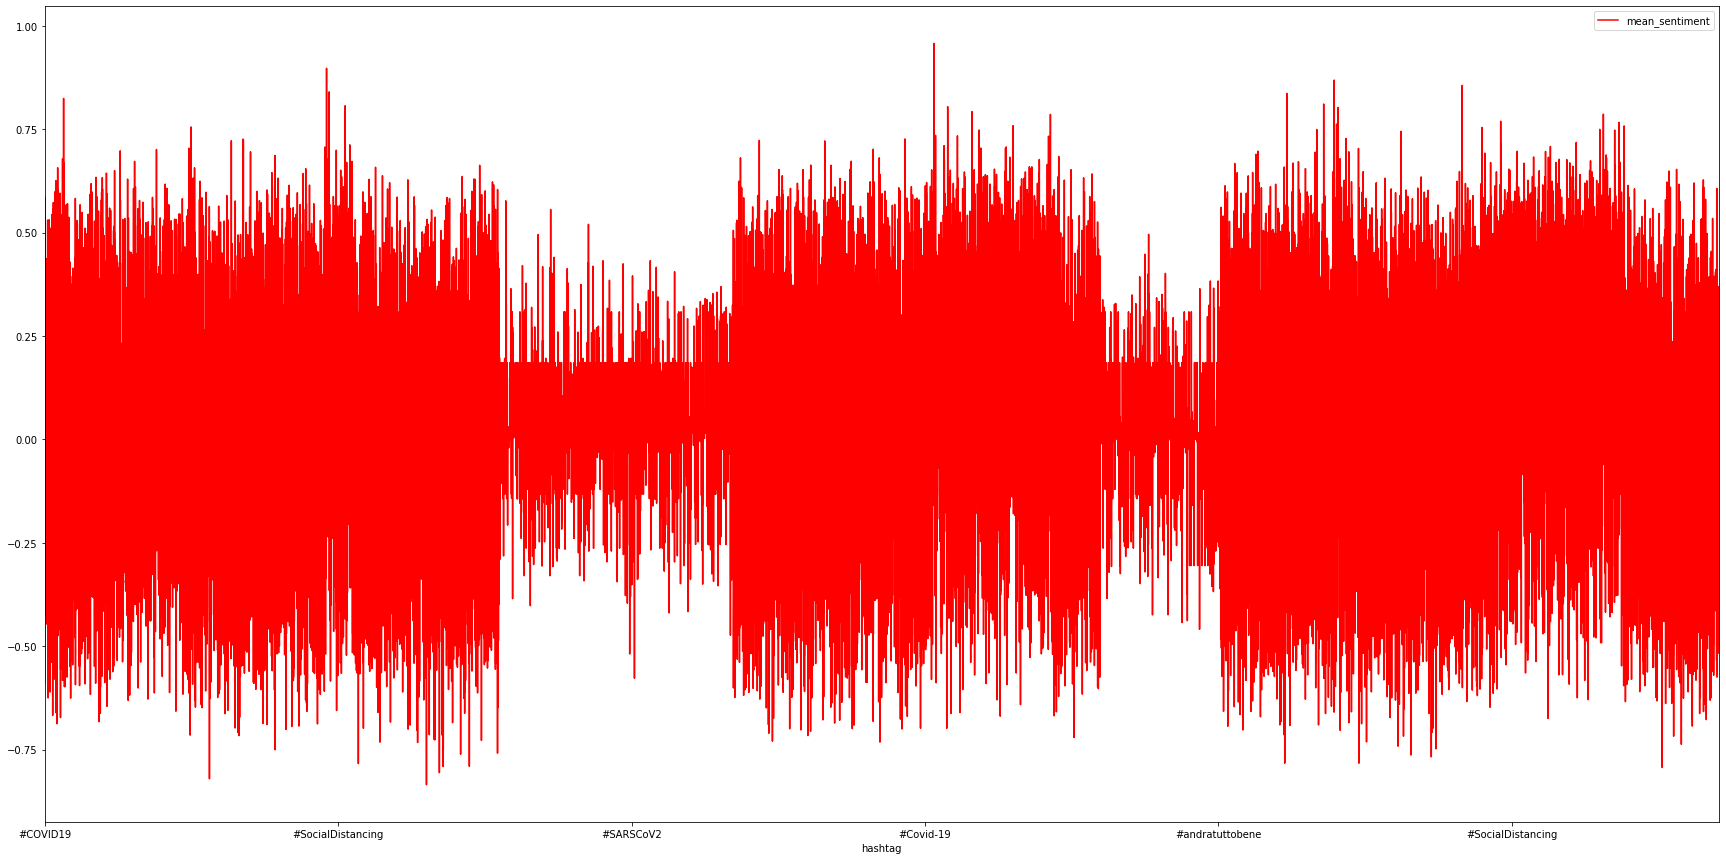

In [61]:
fig, ax = plt.subplots(figsize=(30,15))
Df_sent.plot(kind='line',x='hashtag',y='mean_sentiment',color='red', ax = ax)
plt.show()

In [62]:
%matplotlib inline

#set ggplot style
plt.style.use('ggplot')

Text(0, 0.5, 'mean_sentiment')

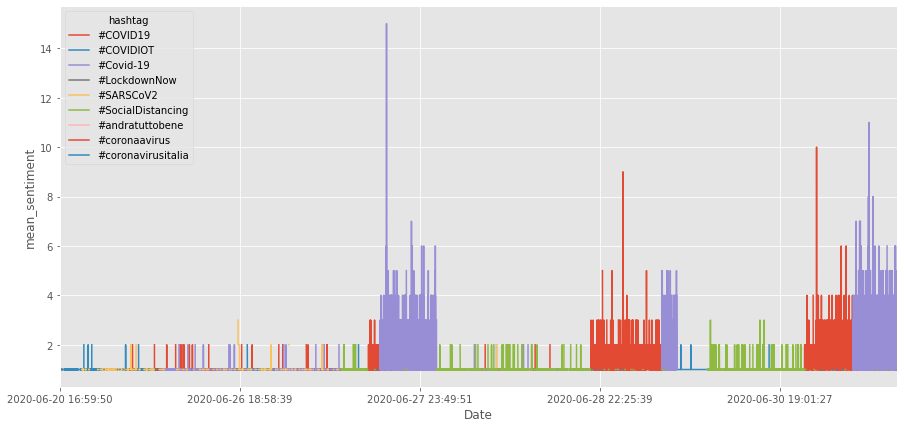

In [63]:
fig, ax = plt.subplots(figsize=(15,7))
Df_sent.groupby(['timestamp','hashtag']).count()['mean_sentiment'].unstack().plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('mean_sentiment')

In [64]:
#Separating each distinct hashtag rows to a unique dataframe:
Df1, Df2, Df3, Df4, Df5, Df6, Df7, Df8, Df9 = [x for _, x in Df_sent.groupby(['hashtag'])]

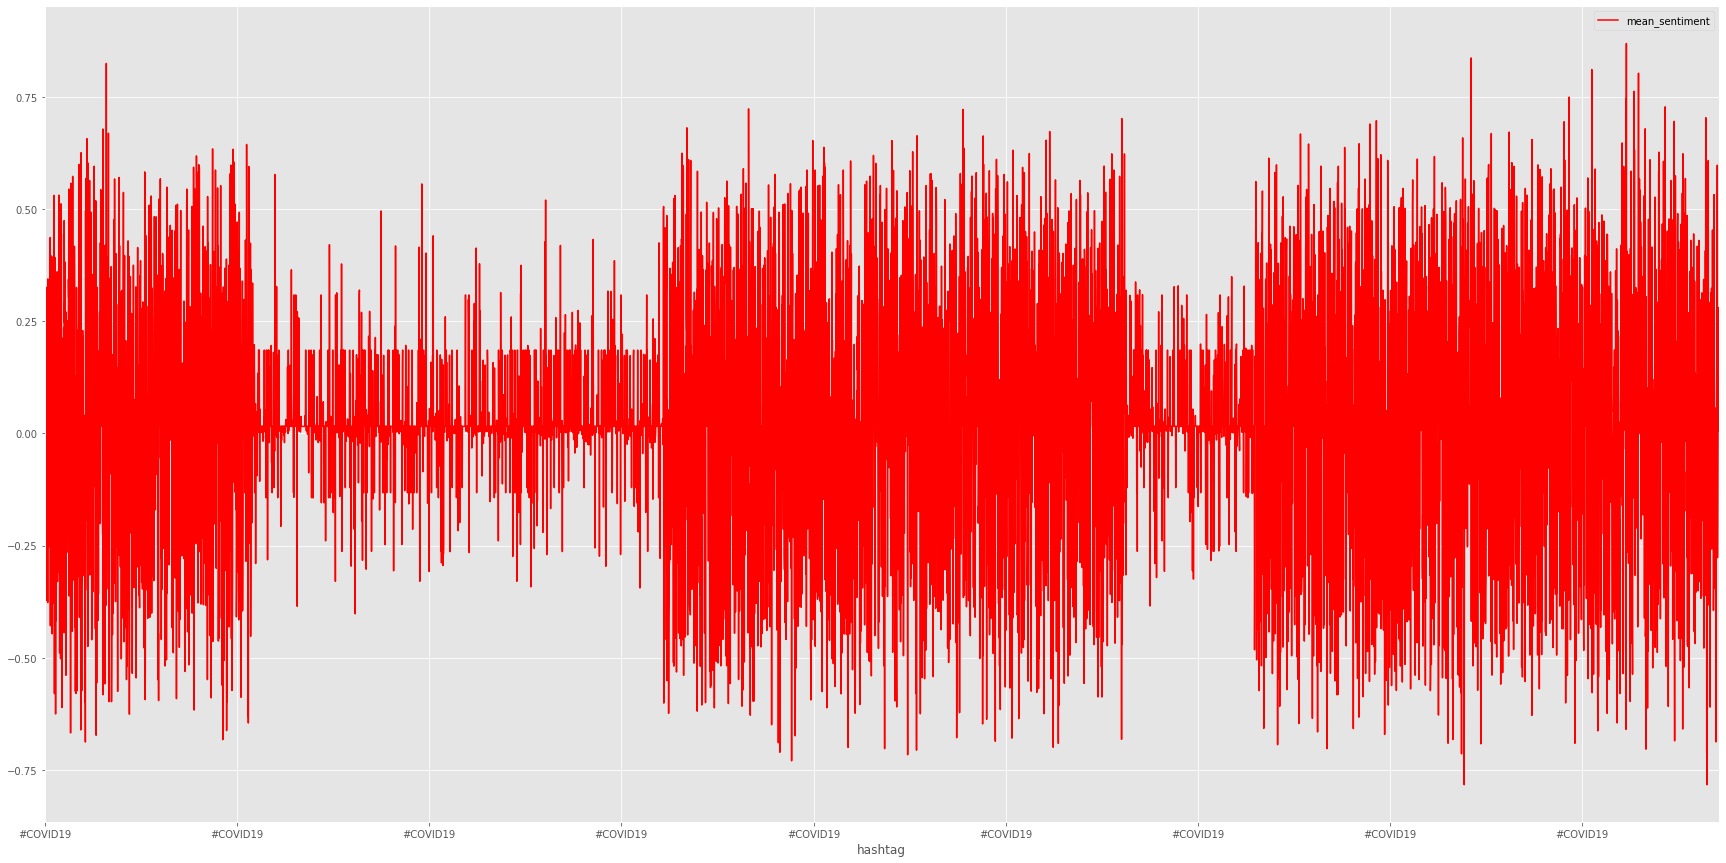

In [65]:
fig, ax = plt.subplots(figsize=(30,15))
Df1.plot(kind='line',x='hashtag',y='mean_sentiment',color='red', ax = ax)
plt.show()

# TF-IDF

In [66]:
texts_bigrams_no_stopwords = [' '.join(doc) for doc in tokenized_texts_bigrams_no_stopwords]

In [67]:
training_tweets    = clean_text(text_column=texts_bigrams_no_stopwords, stopwords_list=stopwords_en)

In [68]:
df_training_tweets = pd.DataFrame({'binary_class' : df_sent['binary_class'],
                                    'three_class' : df_sent['three_class'],
                                    "training_tweets" : texts_bigrams_no_stopwords})

In [69]:

tfidf = TfidfVectorizer(    min_df=5,
                            use_idf=True,
                            analyzer='word',
                            tokenizer=word_tokenize
                            )

text_for_tfidf = [' '.join(tweet) for tweet in training_tweets]
tfidf_matrix   = tfidf.fit_transform(text_for_tfidf)
tfidf_matrix 

<28534x13143 sparse matrix of type '<class 'numpy.float64'>'
	with 312134 stored elements in Compressed Sparse Row format>

In [70]:
tfidf_matrix.shape


(28534, 13143)

In [71]:
tfidf_array = tfidf_matrix.toarray()

In [72]:
#Transform back to a dataframe, assign column names
tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf.get_feature_names())
print(tfidf_df)


              #    '   ''  'covid  'do  'll  'new  'not_going_back'_on  're  \
0      0.036049  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   
1      0.085892  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   
2      0.151060  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   
3      0.069954  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   
4      0.131144  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   
...         ...  ...  ...     ...  ...  ...   ...                  ...  ...   
28529  0.125442  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   
28530  0.068610  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   
28531  0.289782  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   
28532  0.150528  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   
28533  0.054478  0.0  0.0     0.0  0.0  0.0   0.0                  0.0  0.0   

             's  ...  zone  zone_rosse  zones  zoo 

In [73]:
#round values to 3 digits
tfidf_matrix.data = np.round(tfidf_matrix.data, 3)
tfidf_matrix.data

array([0.174, 0.171, 0.227, ..., 0.256, 0.189, 0.054])

In [74]:
tfidf_df.head()

,#,','','covid,'do,'ll,'new,'not_going_back'_on,'re,'s,...,zone,zone_rosse,zones,zoo,zoom,zoonotic,zverev,~,~_min_,~m
0,0.036049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.085892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.151060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.069954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.131144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tf-idf Results:

We use tf-idf technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. It’s a combination of two metrics, term frequency (tf) and inverse document frequency (idf). Mathematically it can be represented as:
                   TF-IDF = Term Frequency (TF) * Inverse Document Frequency 
Generally, both the term frequency and inverse document frequency are scaled logarithmically to prevent bias of longer documents or terms that appear much more frequently relative to other terms: tf(t, d) = 1 + log f t,d .

Similarly, the inverse document frequency of a term given the set of documents can be logarithmically scaled as follows:     idf(t , D) = log 1 + N n t , where N is the number of documents and n t is the number of occurrences of the term t in all documents. TF–IDF is then computed completely as tfidf(t, d, D) = tf(t, d).idf(t, D).

We use scikit-learn's TfidfVectorizer to convert documents from a list of strings to tf-idf scores. The TfidfVectorizer enables us to directly compute the tfidf vectors by taking the raw documents as input and internally computing the term frequencies as well as the inverse document frequencies. Then we run the fit_transform() method to converts the list of strings to something called a sparse matrix. In this case, the matrix represents tf-idf values for all texts. our Vector has become extremely sparse because of large vocabulary. Sparse matrices save on memory by leaving out all zero values, but we want access to those, so next we use the toarray() method to convert the sparse matrices to a numpy array. 
The TF–IDF score is always greater than or equal to zero. We interpret that the closer the TF–IDF score of a term is to 1, the more informative that term is to that document. The closer the score is to zero, the less informative that term is. Since our matrix is sparse we get scores more close to zero.